# Linear Models, Regularization, and Model Selection — A/B/C/D

**Autores:**

## 0. Preparación del entorno
- Instala dependencias si hace falta (`numpy`, `pandas`, `matplotlib`, `scikit-learn`).

In [8]:
# (Opcional) instalar paquetes
# !pip install -q numpy pandas matplotlib scikit-learn


In [4]:
# === Helpers ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from typing import Tuple

def print_section(title: str):
    bar = "=" * len(title)
    print(f"\n{bar}\n{title}\n{bar}")

def train_test_split_np(X, y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    n = X.shape[0]; idx = np.arange(n); rng.shuffle(idx)
    cut = int(n * (1 - test_size))
    tr, te = idx[:cut], idx[cut:]
    return X[tr], X[te], y[tr], y[te]

def add_intercept(X: np.ndarray) -> np.ndarray:
    return np.c_[np.ones((X.shape[0], 1)), X]

def mse(y_true, y_pred): return float(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan


# Parte A. Linear Regression **From Scratch**
### A1. Cargar dataset California Housing, hold-out y estandarizar

In [8]:
print_section("PARTE A: Dataset y estandarización — California Housing REAL")

from sklearn.datasets import fetch_california_housing

# Carga obligatoria del dataset real (sin fallback). Si falla, detenemos.
try:
    data = fetch_california_housing(as_frame=True)
except Exception as e:
    raise RuntimeError(
        "No se pudo cargar California Housing desde scikit-learn. "
        "Necesitas internet o tener la caché local de sklearn. Error original: " + str(e)
    )

df = data.frame.copy()
y = df['MedHouseVal'].values.astype(float)
X = df.drop(columns=['MedHouseVal']).values.astype(float)
feature_names = [c for c in df.columns if c != 'MedHouseVal']

# Hold-out split
X_train, X_test, y_train, y_test = train_test_split_np(X, y, test_size=0.2, seed=42)

# Estandarización con stats del TRAIN
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0); sigma[sigma==0] = 1.0
X_train_std = (X_train - mu) / sigma
X_test_std  = (X_test  - mu) / sigma

print("Shapes:", X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape)
print("Features:", feature_names)



PARTE A: Dataset y estandarización — California Housing REAL


ModuleNotFoundError: No module named 'sklearn'

### A2. OLS en forma cerrada con `numpy`
$\hat{\beta} = (X^\top X)^{-1} X^\top y$ (incluye intercepto)


PARTE A: OLS (numpy)
Intercept (OLS): 2.071942384326375
           MedInc:  0.816141
         HouseAge:  0.116916
         AveRooms: -0.239871
        AveBedrms:  0.286933
       Population: -0.005440
         AveOccup: -0.039611
         Latitude: -0.916570
        Longitude: -0.888463
Test MSE (OLS): 0.524912 | R2: 0.610048


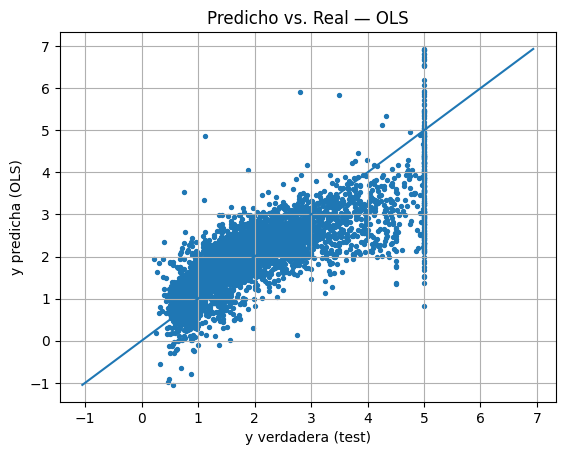

In [10]:
print_section("PARTE A: OLS (numpy)")

Xtr_design = add_intercept(X_train_std)
Xte_design = add_intercept(X_test_std)

XtX = Xtr_design.T @ Xtr_design
Xty = Xtr_design.T @ y_train
beta_hat = np.linalg.pinv(XtX) @ Xty  # forma cerrada con pseudo-inversa para estabilidad

intercept_ols = beta_hat[0]
coef_ols = beta_hat[1:]

print("Intercept (OLS):", intercept_ols)
for name, c in zip(feature_names, coef_ols):
    print(f"  {name:>15}: {c: .6f}")

y_pred_te_ols = Xte_design @ beta_hat
print(f"Test MSE (OLS): {mse(y_test, y_pred_te_ols):.6f} | R2: {r2(y_test, y_pred_te_ols):.6f}")

plt.figure()
plt.scatter(y_test, y_pred_te_ols, s=8)
plt.xlabel("y verdadera (test)"); plt.ylabel("y predicha (OLS)")
plt.title("Predicho vs. Real — OLS")
lims = [min(y_test.min(), y_pred_te_ols.min()), max(y_test.max(), y_pred_te_ols.max())]
plt.plot(lims, lims)
plt.grid(True); plt.show()


### A3. Descenso por gradiente (MSE)
Gradiente de $J(\beta) = \frac{1}{n}\sum (y - X\beta)^2$ es $\nabla J = -\frac{2}{n} X^\top (y - X\beta)$.
Probamos 2 tasas de aprendizaje y comparamos con OLS.


PARTE A: Gradiente Descendente
LR=0.01  Test MSE=0.525226  R2=0.609815
LR=0.1  Test MSE=0.524912  R2=0.610048


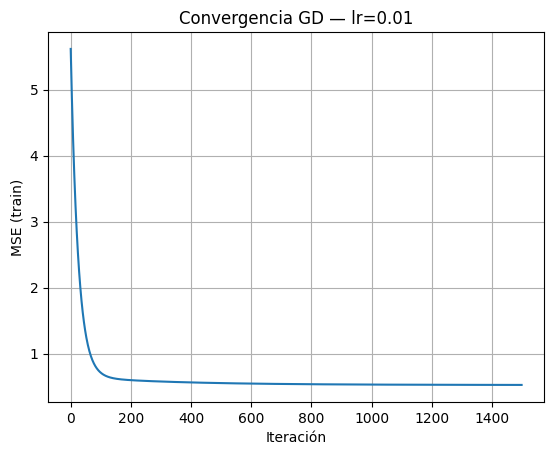

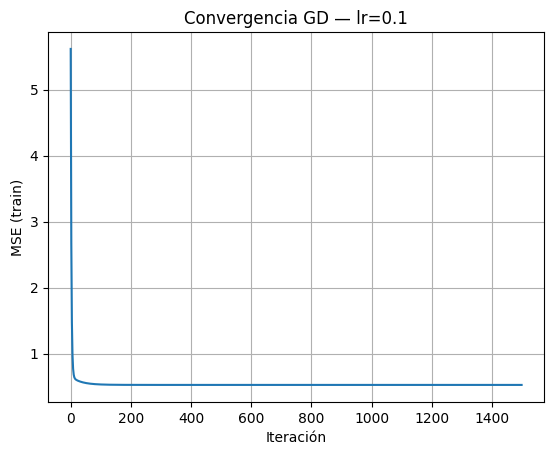

||beta_gd(lr=0.01) - beta_ols||_2 = 0.179323
||beta_gd(lr=0.1) - beta_ols||_2 = 0.000001


In [11]:
print_section("PARTE A: Gradiente Descendente")

def gd_mse(X, y, lr=0.05, iters=1500, seed=0):
    rng = np.random.default_rng(seed)
    m = X.shape[1]
    beta = rng.normal(scale=0.01, size=(m,))
    n = X.shape[0]
    hist = []
    for t in range(iters):
        y_hat = X @ beta
        grad = -(2.0/n) * (X.T @ (y - y_hat))
        beta = beta - lr * grad
        hist.append(mse(y, y_hat))
    return beta, np.array(hist)

lrs = [0.01, 0.1]
hist_list, beta_list = [], []
for lr in lrs:
    b, h = gd_mse(add_intercept(X_train_std), y_train, lr=lr, iters=1500)
    beta_list.append(b); hist_list.append((lr, h))
    yte = add_intercept(X_test_std) @ b
    print(f"LR={lr}  Test MSE={mse(y_test, yte):.6f}  R2={r2(y_test, yte):.6f}")

for lr, hist in hist_list:
    plt.figure()
    plt.plot(np.arange(len(hist)), hist)
    plt.xlabel("Iteración"); plt.ylabel("MSE (train)")
    plt.title(f"Convergencia GD — lr={lr}")
    plt.grid(True); plt.show()

for i, lr in enumerate(lrs):
    diff = np.linalg.norm(beta_list[i] - beta_hat)
    print(f"||beta_gd(lr={lr}) - beta_ols||_2 = {diff:.6f}")


# Parte B. Modelos lineales (scikit-learn)
Confirmamos coeficientes y medimos $R^2$ y MSE.

In [12]:
print_section("PARTE B: LinearRegression (sklearn)")
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_std, y_train)
y_pred_te_lr = lr.predict(X_test_std)
print("Intercept (sklearn):", lr.intercept_)
for name, c in zip(feature_names, lr.coef_):
    print(f"  {name:>15}: {c: .6f}")
print(f"Test MSE (sklearn LR): {mse(y_test, y_pred_te_lr):.6f} | R2: {r2(y_test, y_pred_te_lr):.6f}")



PARTE B: LinearRegression (sklearn)
Intercept (sklearn): 2.0719423843263813
           MedInc:  0.816141
         HouseAge:  0.116916
         AveRooms: -0.239871
        AveBedrms:  0.286933
       Population: -0.005440
         AveOccup: -0.039611
         Latitude: -0.916570
        Longitude: -0.888463
Test MSE (sklearn LR): 0.524912 | R2: 0.610048


# Parte C. Regularización y selección de hiperparámetros
Ridge y Lasso en rejilla de $\alpha$ (10^{-3} a 10^{2}); caminos de coeficientes; k-fold CV; y features polinomiales.


PARTE C: Ridge/Lasso, paths y CV


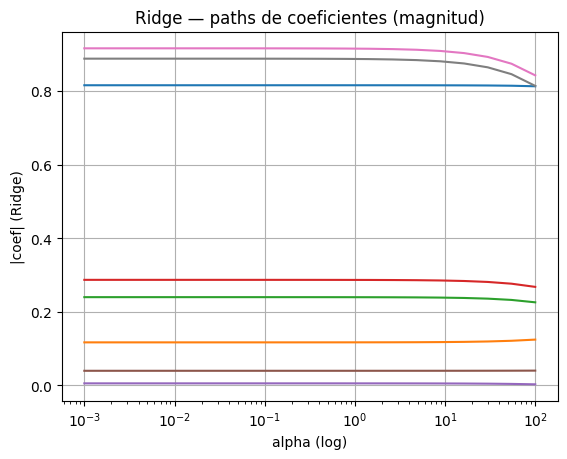

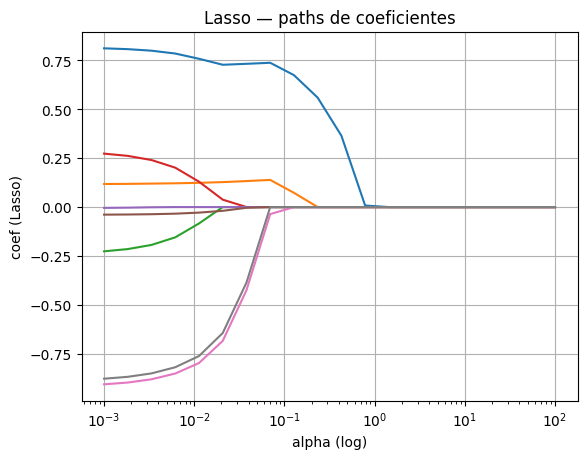

RidgeCV alpha*: 16.237767 | Test MSE: 0.524874 | R2: 0.610077
LassoCV alpha*: 0.001833 | Test MSE: 0.525824 | R2: 0.609371
RidgeCV (poly) alpha*: 100.000000 | Test MSE: 0.444832 | R2: 0.669539


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.734e+00, tolerance: 1.768e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.105e+00, tolerance: 1.768e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

LassoCV (poly) alpha*: 0.020691 | Test MSE: 0.541610 | R2: 0.597644


In [13]:
print_section("PARTE C: Ridge/Lasso, paths y CV")
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures

alphas = np.logspace(-3, 2, 20)

# Paths Ridge
coefs_ridge = []
for a in alphas:
    mdl = Ridge(alpha=a, fit_intercept=True, random_state=0)
    mdl.fit(X_train_std, y_train)
    coefs_ridge.append(mdl.coef_)
coefs_ridge = np.array(coefs_ridge)
plt.figure()
for j in range(X_train_std.shape[1]):
    plt.plot(alphas, np.abs(coefs_ridge[:, j]))
plt.xscale('log'); plt.xlabel("alpha (log)"); plt.ylabel("|coef| (Ridge)")
plt.title("Ridge — paths de coeficientes (magnitud)"); plt.grid(True); plt.show()

# Paths Lasso
coefs_lasso = []
for a in alphas:
    mdl = Lasso(alpha=a, fit_intercept=True, max_iter=15000, random_state=0)
    mdl.fit(X_train_std, y_train)
    coefs_lasso.append(mdl.coef_)
coefs_lasso = np.array(coefs_lasso)
plt.figure()
for j in range(X_train_std.shape[1]):
    plt.plot(alphas, coefs_lasso[:, j])
plt.xscale('log'); plt.xlabel("alpha (log)"); plt.ylabel("coef (Lasso)")
plt.title("Lasso — paths de coeficientes"); plt.grid(True); plt.show()

# CV para elegir alpha (RidgeCV / LassoCV)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_std, y_train)
y_pred_te_ridge = ridge_cv.predict(X_test_std)
print(f"RidgeCV alpha*: {ridge_cv.alpha_:.6f} | Test MSE: {mse(y_test, y_pred_te_ridge):.6f} | R2: {r2(y_test, y_pred_te_ridge):.6f}")

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=30000, random_state=0)
lasso_cv.fit(X_train_std, y_train)
y_pred_te_lasso = lasso_cv.predict(X_test_std)
print(f"LassoCV alpha*: {lasso_cv.alpha_:.6f} | Test MSE: {mse(y_test, y_pred_te_lasso):.6f} | R2: {r2(y_test, y_pred_te_lasso):.6f}")

# Features polinomiales (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
Xtr_poly = poly.fit_transform(X_train_std)
Xte_poly = poly.transform(X_test_std)

ridge_cv_poly = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv_poly.fit(Xtr_poly, y_train)
y_pred_poly_r = ridge_cv_poly.predict(Xte_poly)
print(f"RidgeCV (poly) alpha*: {ridge_cv_poly.alpha_:.6f} | Test MSE: {mse(y_test, y_pred_poly_r):.6f} | R2: {r2(y_test, y_pred_poly_r):.6f}")

lasso_cv_poly = LassoCV(alphas=alphas, cv=5, max_iter=40000, random_state=0)
lasso_cv_poly.fit(Xtr_poly, y_train)
y_pred_poly_l = lasso_cv_poly.predict(Xte_poly)
print(f"LassoCV (poly) alpha*: {lasso_cv_poly.alpha_:.6f} | Test MSE: {mse(y_test, y_pred_poly_l):.6f} | R2: {r2(y_test, y_pred_poly_l):.6f}")
